#**Práctico entregable:**

#**TP No supervisado**



Utilizar la base de jugadores “players_21.csv” disponible en la página de Kaggle https://www.kaggle.com/stefanoleone992/fifa-21-complete-player-dataset?select=players_21.csv. Considerar que la base 2021 no tiene el mismo formato que la base vista en clase, a los nombres de las variables se les agregó una keyword para identificar a qué tipo de habilidad corresponde.

Con la nueva base, realizar un análisis análogo al que realizamos en el cursado de la materia con los datos FIFA2019 (Basarse en las notebooks ntb_clustering_1_fifa2019_Colab, ntb_clustering_2_fifa2019_Colab y ntb3_embeddings_fifa2019_Colab). Realicen comentarios en cada parte (verbose=True ;))


## **Carga de Datos**

### Inicialización del entorno

**Empezamos cargando algunas herramientas para cargar los datos y manipularlos.**

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import random

**Para visualización usaremos principalmente plotly, también seaborn y matplotlib.**

In [2]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

#Graficadores
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [3]:
#Escaladores
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


#Tecnicas de Clustering y graficadores
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from yellowbrick.cluster import SilhouetteVisualizer
#PCA
from sklearn.decomposition import PCA

In [4]:
#Función para Graficar clusters en 3D

def plot_clustering(df, centersDF=pd.DataFrame(),n_ejex='X',n_ejey='Y',n_ejez='Z'):

    pltWidth = 800
    pltHeight = 800
    
    pEvalData = df#.toPandas() para spark

    if not(centersDF.empty):

        pEvalCenters = centersDF#.toPandas()

        eData = go.Scatter3d(
            x=pEvalData.x,
            y=pEvalData.y,
            z=pEvalData.z,
            showlegend=False,
            mode='markers',
            text=pEvalData.name,
            marker=dict(
                size=3,
                color=pEvalData.prediction,   # set color to an array/list of desired values
                colorscale='Rainbow'          # choose a colorscale
              
            ),
            opacity=1.0
        )

        eCenters = go.Scatter3d(
            x=pEvalCenters.x,
            y=pEvalCenters.y,
            z=pEvalCenters.z,
            showlegend=False,
            mode='markers',
            text=pEvalCenters.name.values,
            marker=dict(
                size=3,
                line = dict(
                    width = 1,
                    color = 'black'
                ),
                symbol='x',
                color=pEvalCenters.prediction, # set color to an array/list of desired values
                colorscale='Rainbow'   # choose a colorscale
            ),
            opacity=0.8
        )
        
        data = [eData,eCenters]

        layout = go.Layout(
            title="Clusters",
            width=pltWidth,
            height=pltHeight
        )

    else:

        eData = go.Scatter3d(
            x=pEvalData.x,
            y=pEvalData.y,
            z=pEvalData.z,
            showlegend=False,
            mode='markers',
            text=pEvalData.name,
            marker=dict(
                size=3,
                color=pEvalData.prediction,   # set color to an array/list of desired values
                colorscale='Rainbow'          # choose a colorscale
              
            ),
            opacity=1.0

        )

        data = [eData]

        layout = go.Layout(
            title="Data",
            width=pltWidth,
            height=pltHeight
        )
        
    layout = go.Layout(title="Clusters",
            width=pltWidth,
            height=pltHeight,
            scene = dict(
    xaxis = dict(
        title=n_ejex),
    yaxis = dict(
        title=n_ejey),
    zaxis = dict(
        title=n_ejez),)
        )


    fig = go.Figure(data=data, layout=layout)   
    fig.show(renderer="colab")

**Cargamos los datos bajados de la database de 2021 [Kaggle](https://www.kaggle.com/aayushmishra1512/fifa-2021-complete-player-data) como 'data.csv'.** 

In [5]:
url = 'https://drive.google.com/file/d/1LmV4q3iyFsjaRu2qLg6o7QEl-R_TdmjI/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

df=pd.read_csv(path,sep=',',header=0,index_col=0)

## **Análisis exploratorio**

In [6]:
df.head(3)

player_url  \
sofifa_id                                                      
158023     https://sofifa.com/player/158023/lionel-messi/...   
20801      https://sofifa.com/player/20801/c-ronaldo-dos-...   
200389     https://sofifa.com/player/200389/jan-oblak/210002   

                  short_name                            long_name  age  \
sofifa_id                                                                
158023              L. Messi       Lionel Andrés Messi Cuccittini   33   
20801      Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   35   
200389              J. Oblak                            Jan Oblak   27   

                  dob  height_cm  weight_kg nationality        club_name  \
sofifa_id                                                                  
158023     1987-06-24        170         72   Argentina     FC Barcelona   
20801      1985-02-05        187         83    Portugal         Juventus   
200389     1993-01-07        188         87    Slovenia  Atlético Madrid   

                      league_name  league_rank  overall  potential  value_eur  \
sofifa_id                                                                       
158023     Spain Primera Division          1.0       93         93   67500000   
20801             Italian Serie A          1.0       92         92   46000000   
200389     Spain Primera Division          1.0       91         93   75000000   

           wage_eur player_positions preferred_foot  international_reputation  \
sofifa_id                                                                       
158023       560000       RW, ST, CF           Left                         5   
20801        220000           ST, LW          Right                         5   
200389       125000               GK          Right                         3   

           weak_foot  skill_moves      work_rate             body_type  \
sofifa_id                                                                
158023             4            4     Medium/Low                 Messi   
20801              4            5       High/Low            C. Ronaldo   
200389             3            1  Medium/Medium  PLAYER_BODY_TYPE_259   

          real_face  release_clause_eur  \
sofifa_id                                 
158023          Yes         138400000.0   
20801           Yes          75900000.0   
200389          Yes         159400000.0   

                                                 player_tags team_position  \
sofifa_id                                                                    
158023     #Dribbler, #Distance Shooter, #FK Specialist, ...           CAM   
20801      #Aerial Threat, #Dribbler, #Distance Shooter, ...            LS   
200389                                                   NaN            GK   

           team_jersey_number loaned_from      joined  contract_valid_until  \
sofifa_id                                                                     
158023                   10.0         NaN  2004-07-01                2021.0   
20801                     7.0         NaN  2018-07-10                2022.0   
200389                   13.0         NaN  2014-07-16                2023.0   

          nation_position  nation_jersey_number  pace  shooting  passing  \
sofifa_id                                                                  
158023                 RW                  10.0  85.0      92.0     91.0   
20801                  LS                   7.0  89.0      93.0     81.0   
200389                 GK                   1.0   NaN       NaN      NaN   

           dribbling  defending  physic  gk_diving  gk_handling  gk_kicking  \
sofifa_id                                                                     
158023          95.0       38.0    65.0        NaN          NaN         NaN   
20801           89.0       35.0    77.0        NaN          NaN         NaN   
200389           NaN        NaN     NaN       87.0         92.0        78.0   

           gk_

In [7]:
df.describe()

age     height_cm     weight_kg   league_rank       overall  \
count  18944.000000  18944.000000  18944.000000  18719.000000  18944.000000   
mean      25.225823    181.190773     75.016892      1.357070     65.677787   
std        4.697354      6.825672      7.057140      0.739327      7.002278   
min       16.000000    155.000000     50.000000      1.000000     47.000000   
25%       21.000000    176.000000     70.000000      1.000000     61.000000   
50%       25.000000    181.000000     75.000000      1.000000     66.000000   
75%       29.000000    186.000000     80.000000      1.000000     70.000000   
max       53.000000    206.000000    110.000000      4.000000     93.000000   

          potential     value_eur       wage_eur  international_reputation  \
count  18944.000000  1.894400e+04   18944.000000              18944.000000   
mean      71.086729  2.224813e+06    8675.852513                  1.091850   
std        6.109985  5.102486e+06   19654.774894                  0.361841   
min       47.000000  0.000000e+00       0.000000                  1.000000   
25%       67.000000  3.000000e+05    1000.000000                  1.000000   
50%       71.000000  6.500000e+05    3000.000000                  1.000000   
75%       75.000000  1.800000e+06    7000.000000                  1.000000   
max       95.000000  1.055000e+08  560000.000000                  5.000000   

          weak_foot   skill_moves  release_clause_eur  team_jersey_number  \
count  18944.000000  18944.000000        1.794900e+04        18719.000000   
mean       2.936603      2.363017        4.296353e+06           20.589668   
std        0.667132      0.766469        1.005968e+07           17.057568   
min        1.000000      1.000000        9.000000e+03            1.000000   
25%        3.000000      2.000000        5.250000e+05            9.000000   
50%        3.000000      2.000000        1.100000e+06           18.000000   
75%        3.000000      3.000000        3.200000e+06           27.000000   
max        5.000000      5.000000        2.031000e+08           99.000000   

       contract_valid_until  nation_jersey_number          pace      shooting  \
count          18719.000000           1127.000000  16861.000000  16861.000000   
mean            2021.983332             12.029281     67.668110     52.274954   
std                1.260426              6.674627     10.984862     13.991421   
min             2020.000000              1.000000     25.000000     16.000000   
25%             2021.000000              6.000000     62.000000     42.000000   
50%             2022.000000             12.000000     68.000000     54.000000   
75%             2023.000000             18.000000     75.000000     63.000000   
max             2028.000000             27.000000     96.000000     93.000000   

            passing     dribbling     defending        physic    gk_diving  \
count  16861.000000  16861.000000  16861.000000  16861.000000  2083.000000   
mean      57.139434     62.455430     51.316292     64.458988    65.164186   
std       10.273655     10.048706     16.405179      9.746706     7.710474   
min       25.000000     25.000000     15.000000     28.000000    45.000000   
25%       50.000000     57.000000     36.000000     58.000000    60.000000   
50%       58.000000     64.000000     56.000000     66.000000    65.000000   
75%       64.000000     69.000000     64.000000     72.000000    70.000000   
max       93.000000     95.000000     91.000000     91.000000    90.000000   

       gk_handling   gk_kicking  gk_reflexes     gk_speed  gk_positioning  \
count  2083.000000  2083.000000  2083.000000  2083.000000     2083.000000   
mean     62.889102    61.719635    66.108017    37.203553       63.171867   
std       7.328945     7.575184     8.126601    10.714523        8.565969   
min      43.000000    35.000000    44.000000    12.000000       38.000000   
25%      58.000000    57.000000    60.000000    28.000000       57.000000   
50%      63.

In [8]:
print('Número de filas dataframe original:',len(df.index))

Número de filas dataframe original: 18944


In [9]:
print(np.array(df.columns))
print(len(df.columns))

['player_url' 'short_name' 'long_name' 'age' 'dob' 'height_cm' 'weight_kg'
 'nationality' 'club_name' 'league_name' 'league_rank' 'overall'
 'potential' 'value_eur' 'wage_eur' 'player_positions' 'preferred_foot'
 'international_reputation' 'weak_foot' 'skill_moves' 'work_rate'
 'body_type' 'real_face' 'release_clause_eur' 'player_tags'
 'team_position' 'team_jersey_number' 'loaned_from' 'joined'
 'contract_valid_until' 'nation_position' 'nation_jersey_number' 'pace'
 'shooting' 'passing' 'dribbling' 'defending' 'physic' 'gk_diving'
 'gk_handling' 'gk_kicking' 'gk_reflexes' 'gk_speed' 'gk_positioning'
 'player_traits' 'attacking_crossing' 'attacking_finishing'
 'attacking_heading_accuracy' 'attacking_short_passing'
 'attacking_volleys' 'skill_dribbling' 'skill_curve' 'skill_fk_accuracy'
 'skill_long_passing' 'skill_ball_control' 'movement_acceleration'
 'movement_sprint_speed' 'movement_agility' 'movement_reactions'
 'movement_balance' 'power_shot_power' 'power_jumping' 'power_stamina'


Se tienen 105 columnas con atributos de 18944 jugadores, desde atributos idenficatorios, personales, ténicos, etc.

Desde '***pace***' hasta '***gk_positioning***', pareciera que los atibuots estan separando entre arqueros y el resto. 
Luego de '***player_traits***' hasta '***goalkeeping_reflexes***' son habilidades de los jugadores, donde todos tienen valores, salvo '***defending_marking***', que tiene todos NAN

Existen 3 columnas con datos referidos a la posicion del jugar ***player_positions***, ***team_position*** y ***nation_position***. 
***player_positions*** tiene más de un valor por jugador.

Desde ***'ls'*** hasta ***'rb'***, son columnas con puntajes del jugador en esas posiciones, por alguna razon hay algunas que tienen el valor númerico y un ***'+'*** otro número

La variable **'Overall'** se calcula usando otras variables de desempeño del jugador (skills_ratings).

La variable 'Overall' es discreta, así como las otras de desempeño según habilidad ('Crossing',
       'Finishing', 'HeadingAccuracy', etc.), tomando valores enteros entre 0 y 100


**Realizamos el histograma de la variable "Overall" (Desempeño global)**

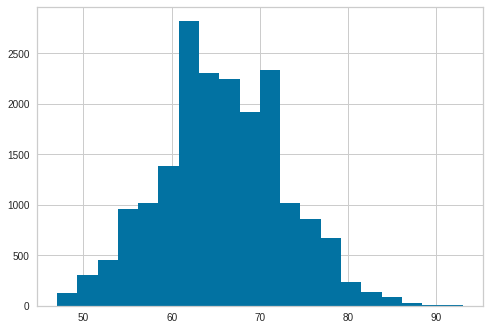

In [10]:
df.overall.hist(bins = 20)

**Conteos por posiciones**

In [11]:
pd.DataFrame(df.team_position.value_counts().sort_index())

team_position
CAM            286
CB             128
CDM            181
CF              13
CM              76
GK             681
LAM             25
LB             553
LCB            681
LCM            425
LDM            248
LF              13
LM             420
LS             224
LW             170
LWB             78
RAM             25
RB             553
RCB            681
RCM            425
RDM            248
RES           3163
RF              13
RM             420
RS             224
RW             170
RWB             78
ST             452
SUB           8065

In [12]:
club_avg_overall=df.groupby("club_name")["overall"].mean().reset_index().sort_values("overall",ascending=False)
club_avg_overall.head(8)

club_name    overall
216  FC Bayern München  81.045455
489        Real Madrid  79.250000
131            Chelsea  79.212121
214       FC Barcelona  78.909091
374          Liverpool  78.575758
330              Inter  78.000000
387  Manchester United  77.818182
386    Manchester City  77.484848

### **Preparación de los datos**

**Retiramos jugadores con bajo Desempeño global ("Overall"), reducimos el tamaño de la base y consideramos Variables de desempeño por habilidad(skills_ratings)**

In [13]:
df_overall_70=df[(df['overall']>70)]

SOURCE:https://sofifa.com/

ATTACKING
* Crossing
* Finishing
* Heading Accuracy
* Short Passing
* Volleys

SKILL
* Dribbling
* Curve
* FK Accuracy
* Long Passing
* Ball Control

MOVEMENT
* Acceleration
* Sprint Speed
* Agility
* Reactions
* Balance

POWER
* Shot Power
* Jumping
* Stamina
* Strength
* Long Shots

MENTALITY
* Aggression
* Interceptions
* Positioning
* Vision
* Penalties
* Composure

DEFENDING
* Defensive Awareness
* Standing Tackle
* Sliding Tackle

GOALKEEPING
* GK Diving
* GK Handling
* GK Kicking
* GK Positioning
* GK Reflexes

In [14]:
skills_ratings=df_overall_70.loc[:,'attacking_crossing':'goalkeeping_reflexes'].columns
print(skills_ratings)
df_skills=df_overall_70[skills_ratings] #base, sólo con desempeños según habilidad (numéricas)
len(skills_ratings)

Index(['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes'],
      dtype='object')


34

In [15]:
df_skills.head(4)

attacking_crossing  attacking_finishing  \
sofifa_id                                            
158023                     85                   95   
20801                      84                   95   
200389                     13                   11   
188545                     71                   94   

           attacking_heading_accuracy  attacking_short_passing  \
sofifa_id                                                        
158023                             70                       91   
20801                              90                       82   
200389                             15                       43   
188545                             85                       84   

           attacking_volleys  skill_dribbling  skill_curve  skill_fk_accuracy  \
sofifa_id                                                                       
158023                    88               96           93                 94   
20801                     86               88           81                 76   
200389                    13               12           13                 14   
188545                    89               85           79                 85   

           skill_long_passing  skill_ball_control  movement_acceleration  \
sofifa_id                                                                  
158023                     91                  96                     91   
20801                      77                  92                     87   
200389                     40                  30                     43   
188545                     70                  88                     77   

           movement_sprint_speed  movement_agility  movement_reactions  \
sofifa_id                                                                
158023                        80                91                  94   
20801                         91                87                  95   
200389                        60                67                  88   
188545                        78                77                  93   

           movement_balance  power_shot_power  power_jumping  power_stamina  \
sofifa_id                                                                     
158023                   95                86             68             72   
20801                    71                94             95             84   
200389                   49                59             78             41   
188545                   82                89             84             76   

           power_strength  power_long_shots  mentality_aggression  \
sofifa_id                                                           
158023                 69                94                    44   
20801                  78                93                    63   
200389                 78                12                    34   
188545                 86                85                    81   

           mentality_interceptions  mentality_positioning  mentality_vision  \
sofifa_id                                                                     
158023                          40                     93                95   
20801                           29                     95                82   
200389                          19                     11                65   
188545                          49                     94                79   

           mentality_penalties  mentality_composure  defending_marking  \
sofifa_id                                                                
158023                      75                   96                NaN   
20801                       84                   95                NaN   
200389                      11                   68                NaN   
188545                      88                   88                NaN   

           defending_standing_tackle  defending_sliding_tackle  \
sofifa_id               

In [16]:
print('Número de filas:',len(df_skills.index))

Número de filas: 4512


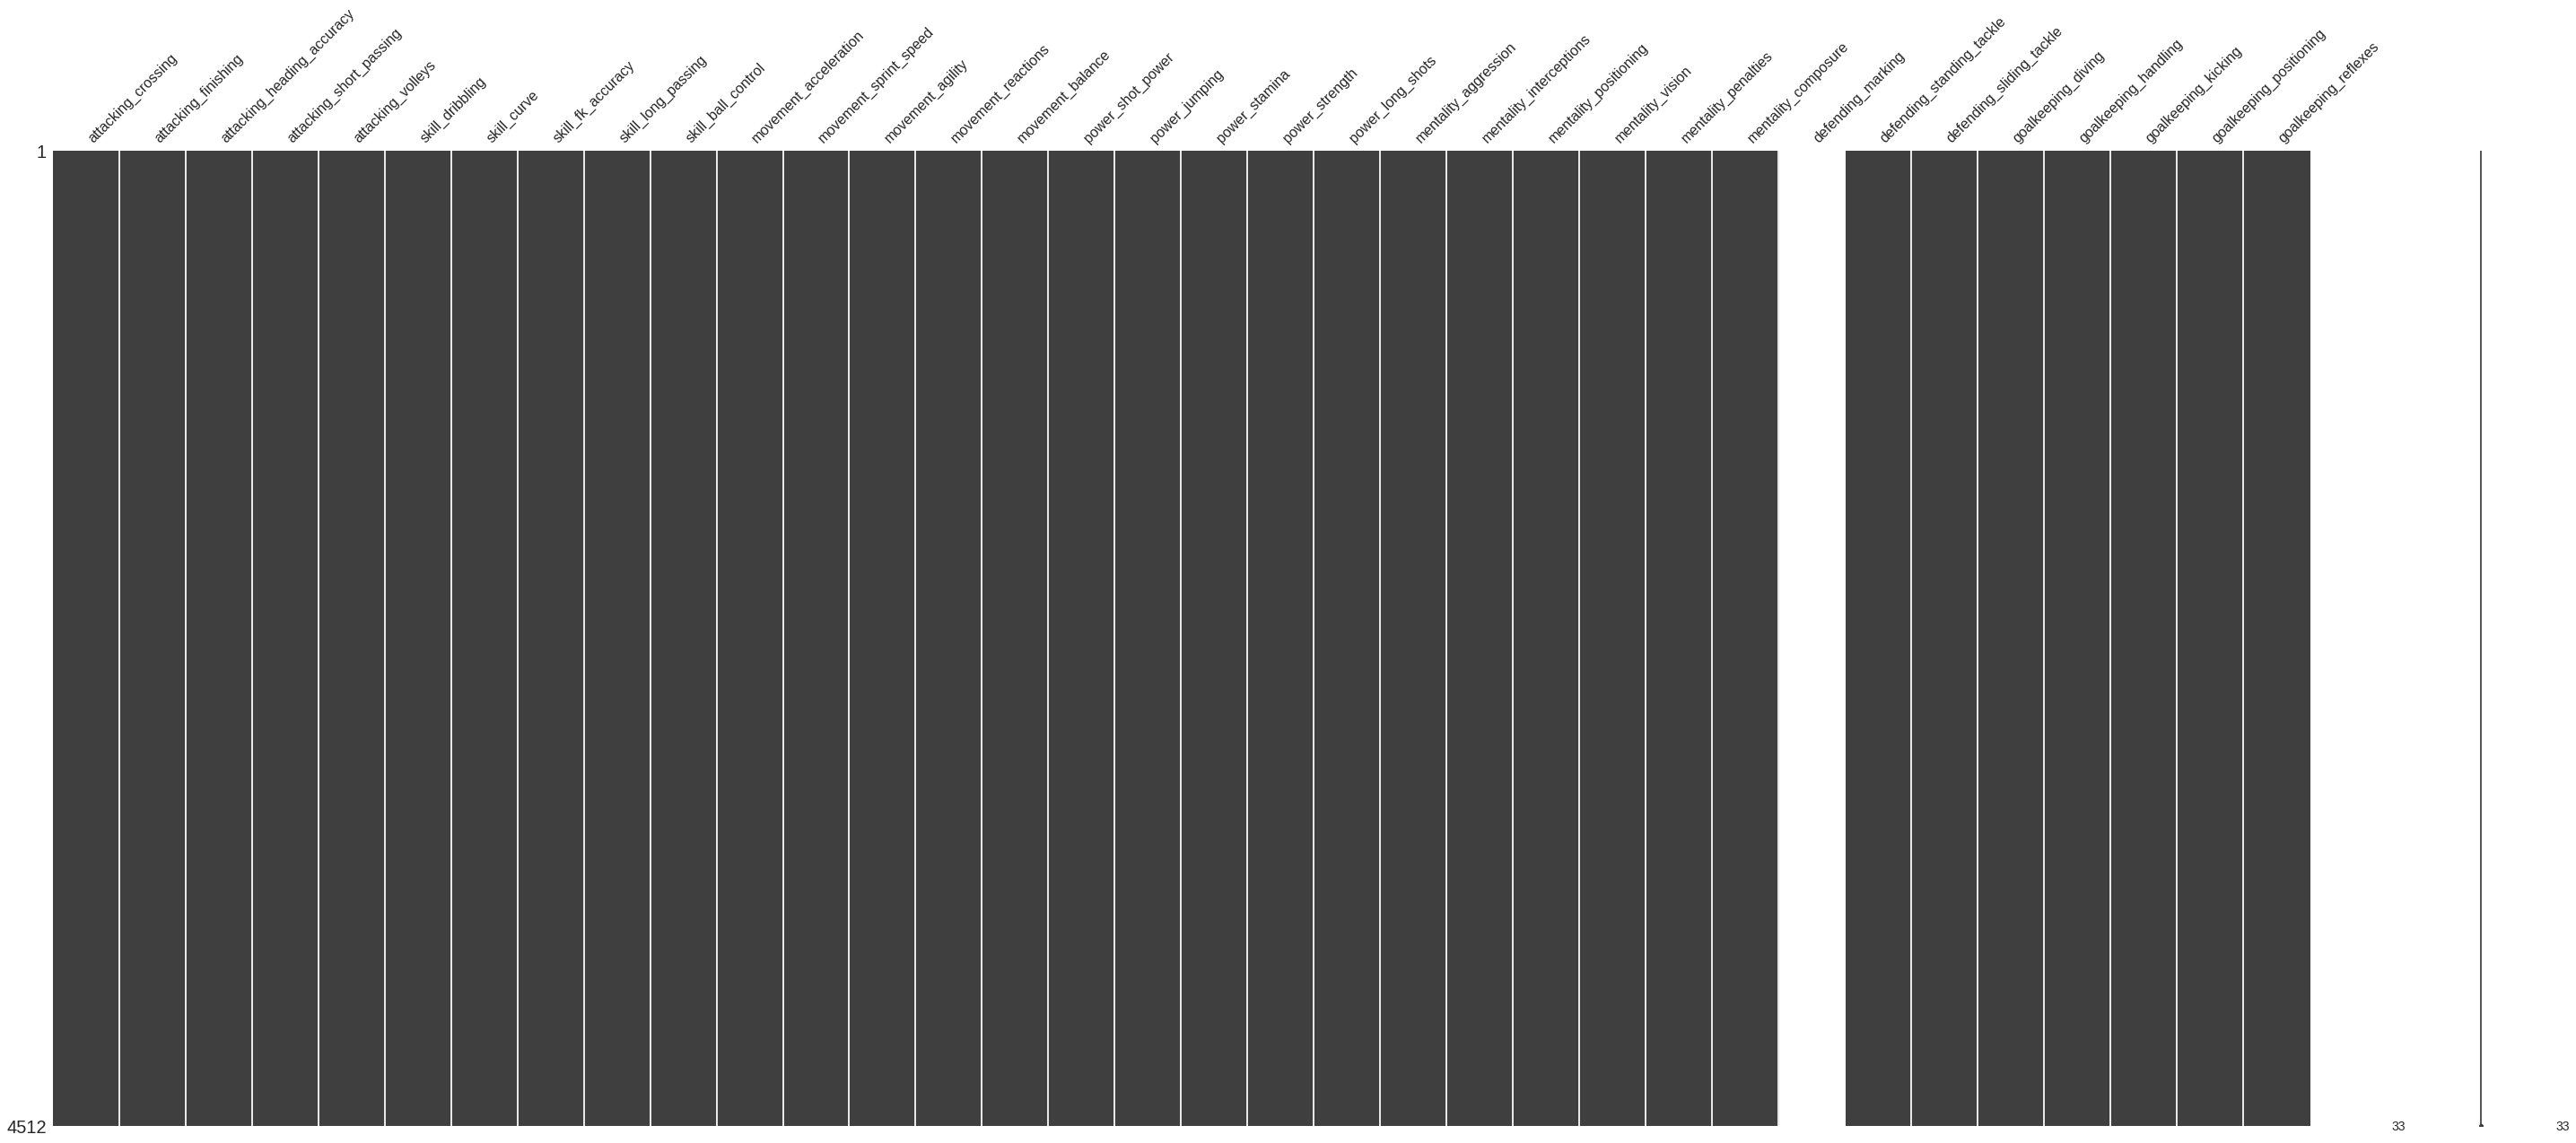

In [17]:
import missingno as msno
msno.matrix(df_skills,figsize=(50, 20))

Vamos a eliminar la variable '***defending_marking***' que tiene todos NAN

In [18]:
col_del=['defending_marking']  
skills_ratings=[x for x in skills_ratings if x not in col_del]

**Se crea el jugador perfecto para ver a donde se ubica en nuestra visualización**

In [19]:
MachineGunDict={'short_name':'MachineGun','Overall':99}
for skills in skills_ratings:
    MachineGunDict[skills]=99
    
df_overall_70=df_overall_70.append(MachineGunDict,ignore_index=True)

In [20]:
df_skills=df_overall_70[skills_ratings]
df_skills

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                     85                   95                          70   
1                     84                   95                          90   
2                     13                   11                          15   
3                     71                   94                          85   
4                     85                   87                          62   
...                  ...                  ...                         ...   
4508                  68                   68                          48   
4509                  67                   55                          51   
4510                  14                    6                          13   
4511                  59                   70                          50   
4512                  99                   99                          99   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
0                          91                 88               96   
1                          82                 86               88   
2                          43                 13               12   
3                          84                 89               85   
4                          87                 87               95   
...                       ...                ...              ...   
4508                       69                 61               73   
4509                       73                 51               73   
4510                       21                  9                9   
4511                       75                 61               73   
4512                       99                 99               99   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0              93                 94                  91                  96   
1              81                 76                  77                  92   
2              13                 14                  40                  30   
3              79                 85                  70                  88   
4              88                 89                  81                  95   
...           ...                ...                 ...                 ...   
4508           53                 42                  57                  71   
4509           81                 63                  71                  75   
4510           14                 11                  21                  18   
4511           59                 59                  73                  74   
4512           99                 99                  99                  99   

      movement_acceleration  movement_sprint_speed  movement_agility  \
0                        91                     80                91   
1                        87                     91                87   
2                        43                     60                67   
3                        77                     78                77   
4                        94                     89                96   
...                     ...                    ...               ...   
4508                     83                     82                81   
4509                     79                     73                80   
4510                     28                     16                21   
4511                     66                     67                74   
4512                     99                     99                99   

      movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                     94                95                86             68   
1                     95                71                94             95   
2                     88                49                59             78   
3                     93                82                89             84   
4                     91       

In [21]:
n_skills=len(skills_ratings )

In [22]:
print(n_skills,'Habilidades Númericas')

33 Habilidades Númericas


##**Evaluación visual  e intuitiva de a dos variables por vez.**

Existen 33 habilidades númericas generando más de 1000 combinaciones, si bien se puede graficar todas las combinaciones entre si, se hace algo pesado y visualmente no aporta mucho. 

Por esto vamos a probar algunas formas un poco menos engorrosas,

**Ver combinación especifica**

In [23]:
for i in enumerate(skills_ratings):
  print(i)

(0, 'attacking_crossing')
(1, 'attacking_finishing')
(2, 'attacking_heading_accuracy')
(3, 'attacking_short_passing')
(4, 'attacking_volleys')
(5, 'skill_dribbling')
(6, 'skill_curve')
(7, 'skill_fk_accuracy')
(8, 'skill_long_passing')
(9, 'skill_ball_control')
(10, 'movement_acceleration')
(11, 'movement_sprint_speed')
(12, 'movement_agility')
(13, 'movement_reactions')
(14, 'movement_balance')
(15, 'power_shot_power')
(16, 'power_jumping')
(17, 'power_stamina')
(18, 'power_strength')
(19, 'power_long_shots')
(20, 'mentality_aggression')
(21, 'mentality_interceptions')
(22, 'mentality_positioning')
(23, 'mentality_vision')
(24, 'mentality_penalties')
(25, 'mentality_composure')
(26, 'defending_standing_tackle')
(27, 'defending_sliding_tackle')
(28, 'goalkeeping_diving')
(29, 'goalkeeping_handling')
(30, 'goalkeeping_kicking')
(31, 'goalkeeping_positioning')
(32, 'goalkeeping_reflexes')


In [24]:
print(skills_ratings)

['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']


In [25]:
#@title Seleccion de Skills
skill_1 = "attacking_volleys" #@param ["attacking_crossing", "attacking_finishing", "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed", "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength", "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning", "mentality_vision", "mentality_penalties", "mentality_composure", "defending_standing_tackle", "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", "goalkeeping_reflexes"]
skill_2 = "attacking_short_passing" #@param ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

print(f'Skills seleccionados:\n{skill_1} y {skill_2}')

Skills seleccionados:
attacking_volleys y attacking_short_passing


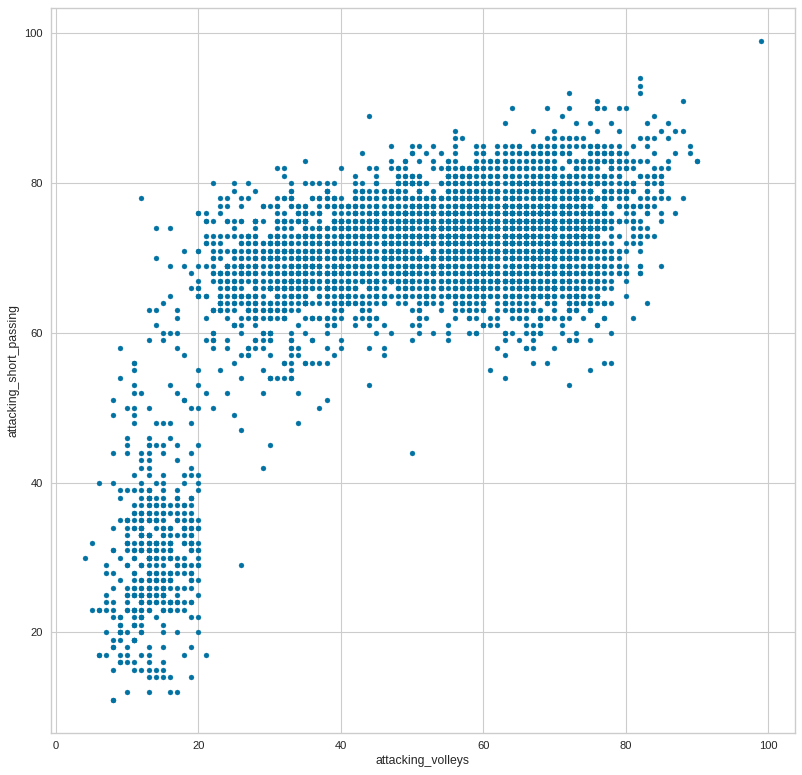

In [26]:
plt.figure(figsize=(12,12), dpi=80)
plt.scatter(df_skills[skill_1], y=df_skills[skill_2],s=20,cmap='PiYG')

plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

**Combinaciones random**

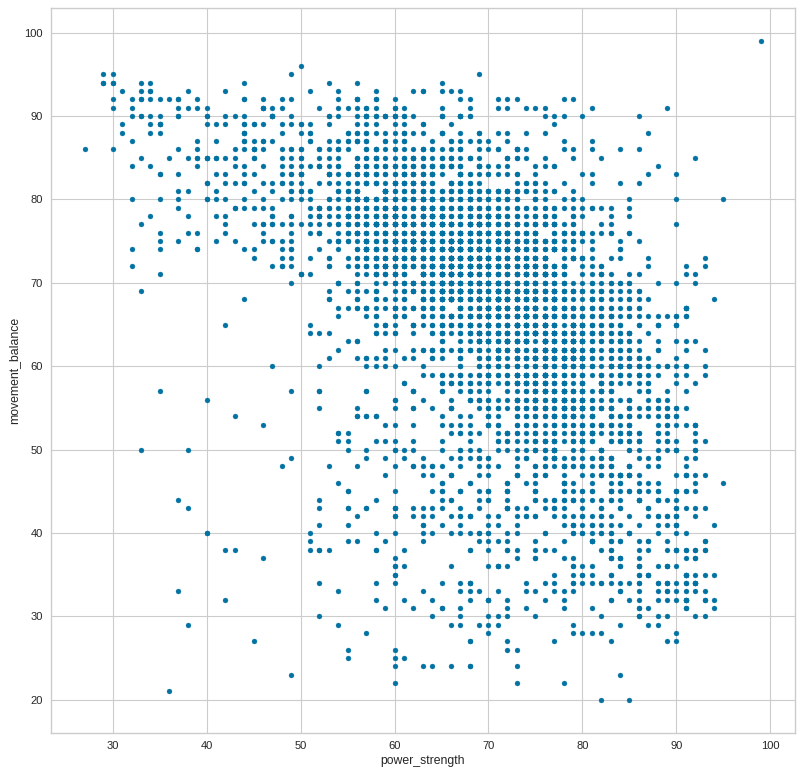

In [90]:
import random
skill_1,skill_2=random.sample(skills_ratings,2)
plt.figure(figsize=(12,12), dpi=80)
plt.scatter(df_skills[skill_1], y=df_skills[skill_2],s=20,cmap='PiYG')

plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

**Varias variables random**

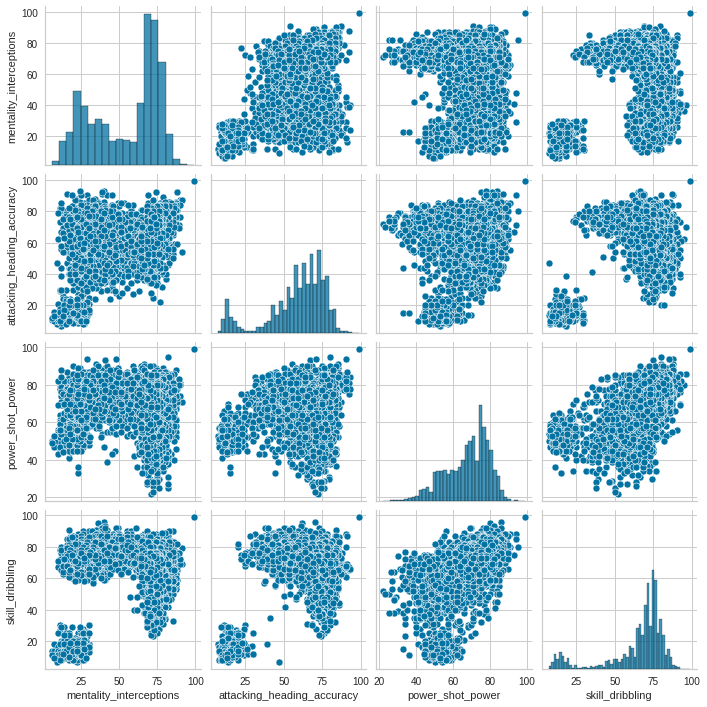

In [28]:
variables=4
sns.pairplot(df_skills[random.sample(skills_ratings,variables)])

###**Visualización de Arqueros**

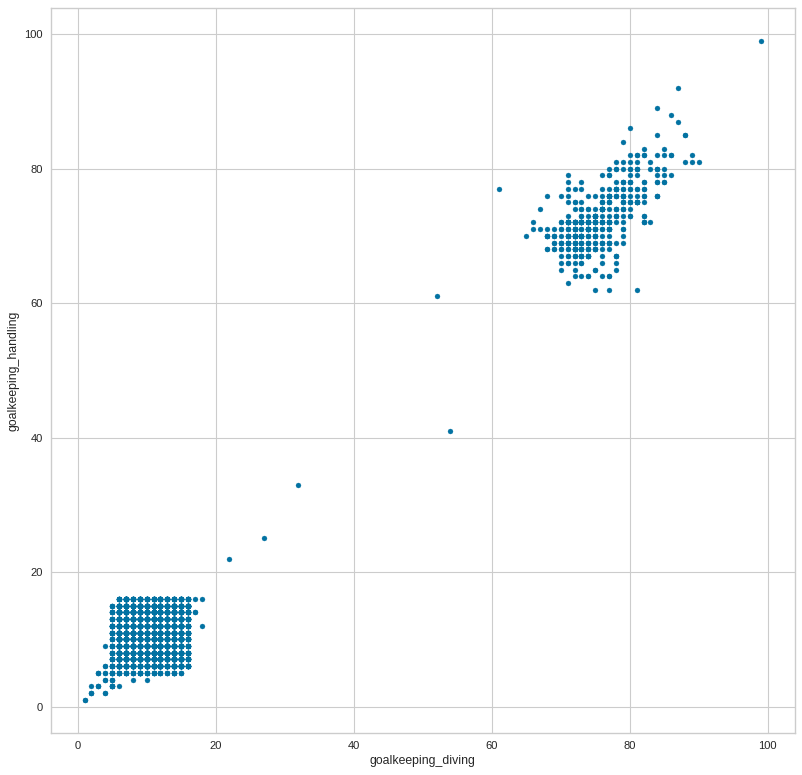

In [29]:
skill_1=skills_ratings[28]
skill_2=skills_ratings[29]

skill_1,skill_2

plt.figure(figsize=(12,12), dpi=80)
plt.scatter(df_skills[skill_1], y=df_skills[skill_2],s=20,cmap='PiYG')

plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

Se ve muy a simple vista en varias de las combianciones de 2 habilidades que hay un grupo muy diferenciado, observando las habilidades de arqueros queda claro que este **grupo es el de arqueros, por lo que lo vamos a separar del DataSet**

In [30]:
df_skills_sin_arqueros=df_skills[(df_overall_70['player_positions']!='GK')&(df_overall_70['team_position']!='GK')]
df_overall_70_SGK=df_overall_70[(df_overall_70['player_positions']!='GK')&(df_overall_70['team_position']!='GK')].reset_index()

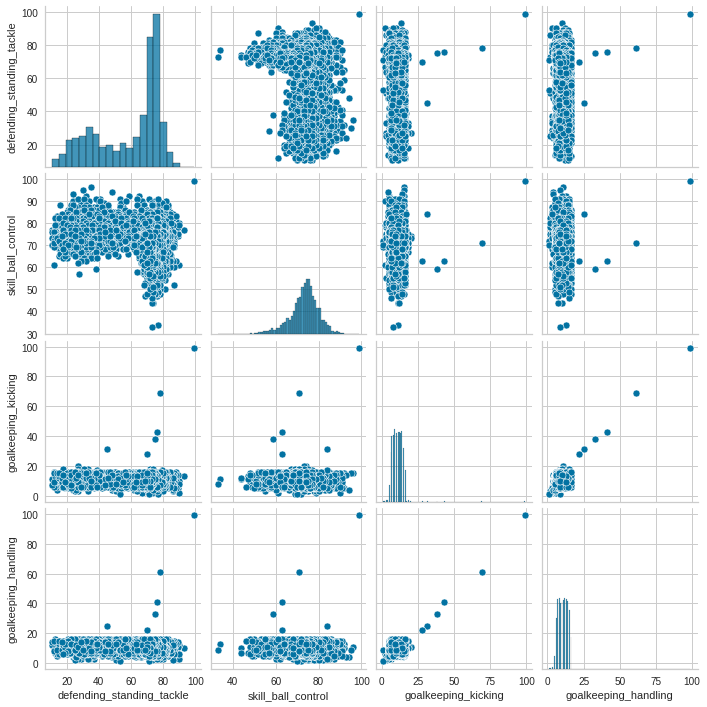

In [31]:
variables=4
sns.pairplot(df_skills_sin_arqueros[random.sample(skills_ratings,variables)])

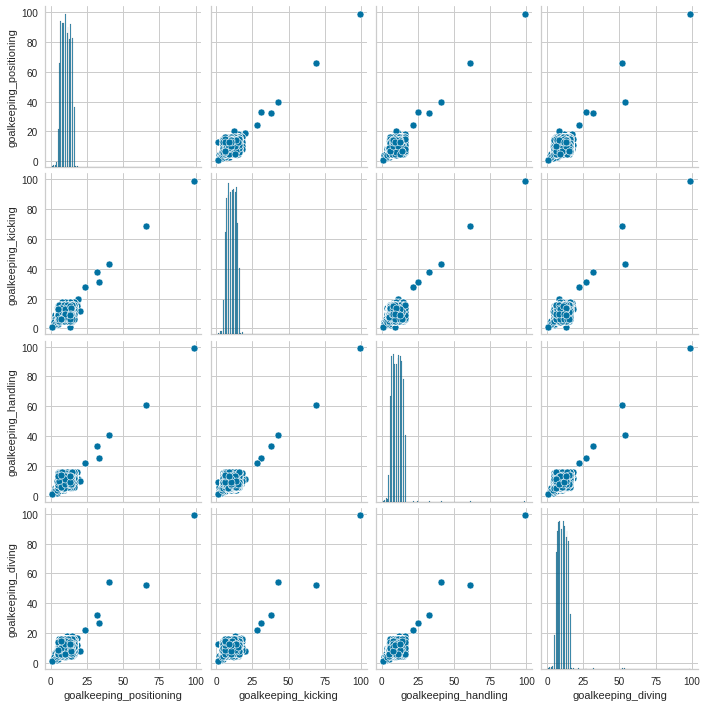

In [32]:
sns.pairplot(df_skills_sin_arqueros[random.sample(skills_ratings[28:32],4)])

Ya no se observa ese grupo tan diferenciado que antes se encontraba, el punto alejado es el jugador ideal que creamos anteriormente

In [177]:
data=df_skills_sin_arqueros

##**Uso de técnicas de clustering: k-Medias, Mean Shift y Alguna jerárquica**
(sugerencia: usar 'cityblock' como distancia en el jerárquico).

###**k-Medias**

Función para hacer el estudio

In [34]:
def kmeans_estudio(data,iter=5,clusters_max=20,metric='euclidean'): #Función para hacer el estudio de Kmeans
  inercia=[] #Se guarda la inercia para hacer el grafico dle codo
  silueta=[] #Para guardar el coeficiente de silueta

  #Definicion de Subplots para graficar los graficos de silueta de cada opción
  fig, ax = plt.subplots(int(clusters_max/2),2)

  for i in range(2,clusters_max): #Prueba desde 2 hasta la cantidad maxima de clusters que se define
    #Definimos el kmeans
    km = KMeans(n_clusters=i, max_iter=iter,random_state=0)
    
    #Agrega Resultados a las listas para graficarlas
    silueta.append(silhouette_score(data, km.fit(data).labels_))
    inercia.append(km.inertia_)

    #Para elegir los subplots
    q, mod = divmod(i, 2)

    #Visulizador de Silueta
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(data)
    ax[q][mod].title.set_text(f'clusters={i}')

  pd.DataFrame(inercia,index=range(2,clusters_max)).plot(figsize=(25,6*int(clusters_max/2)),ax=ax[0][0])
  ax[0][0].title.set_text('Codo')
  pd.DataFrame(silueta,index=range(2,clusters_max)).plot(figsize=(25,6*int(clusters_max/2)),ax=ax[0][1])
  ax[0][1].title.set_text('Silueta_score')

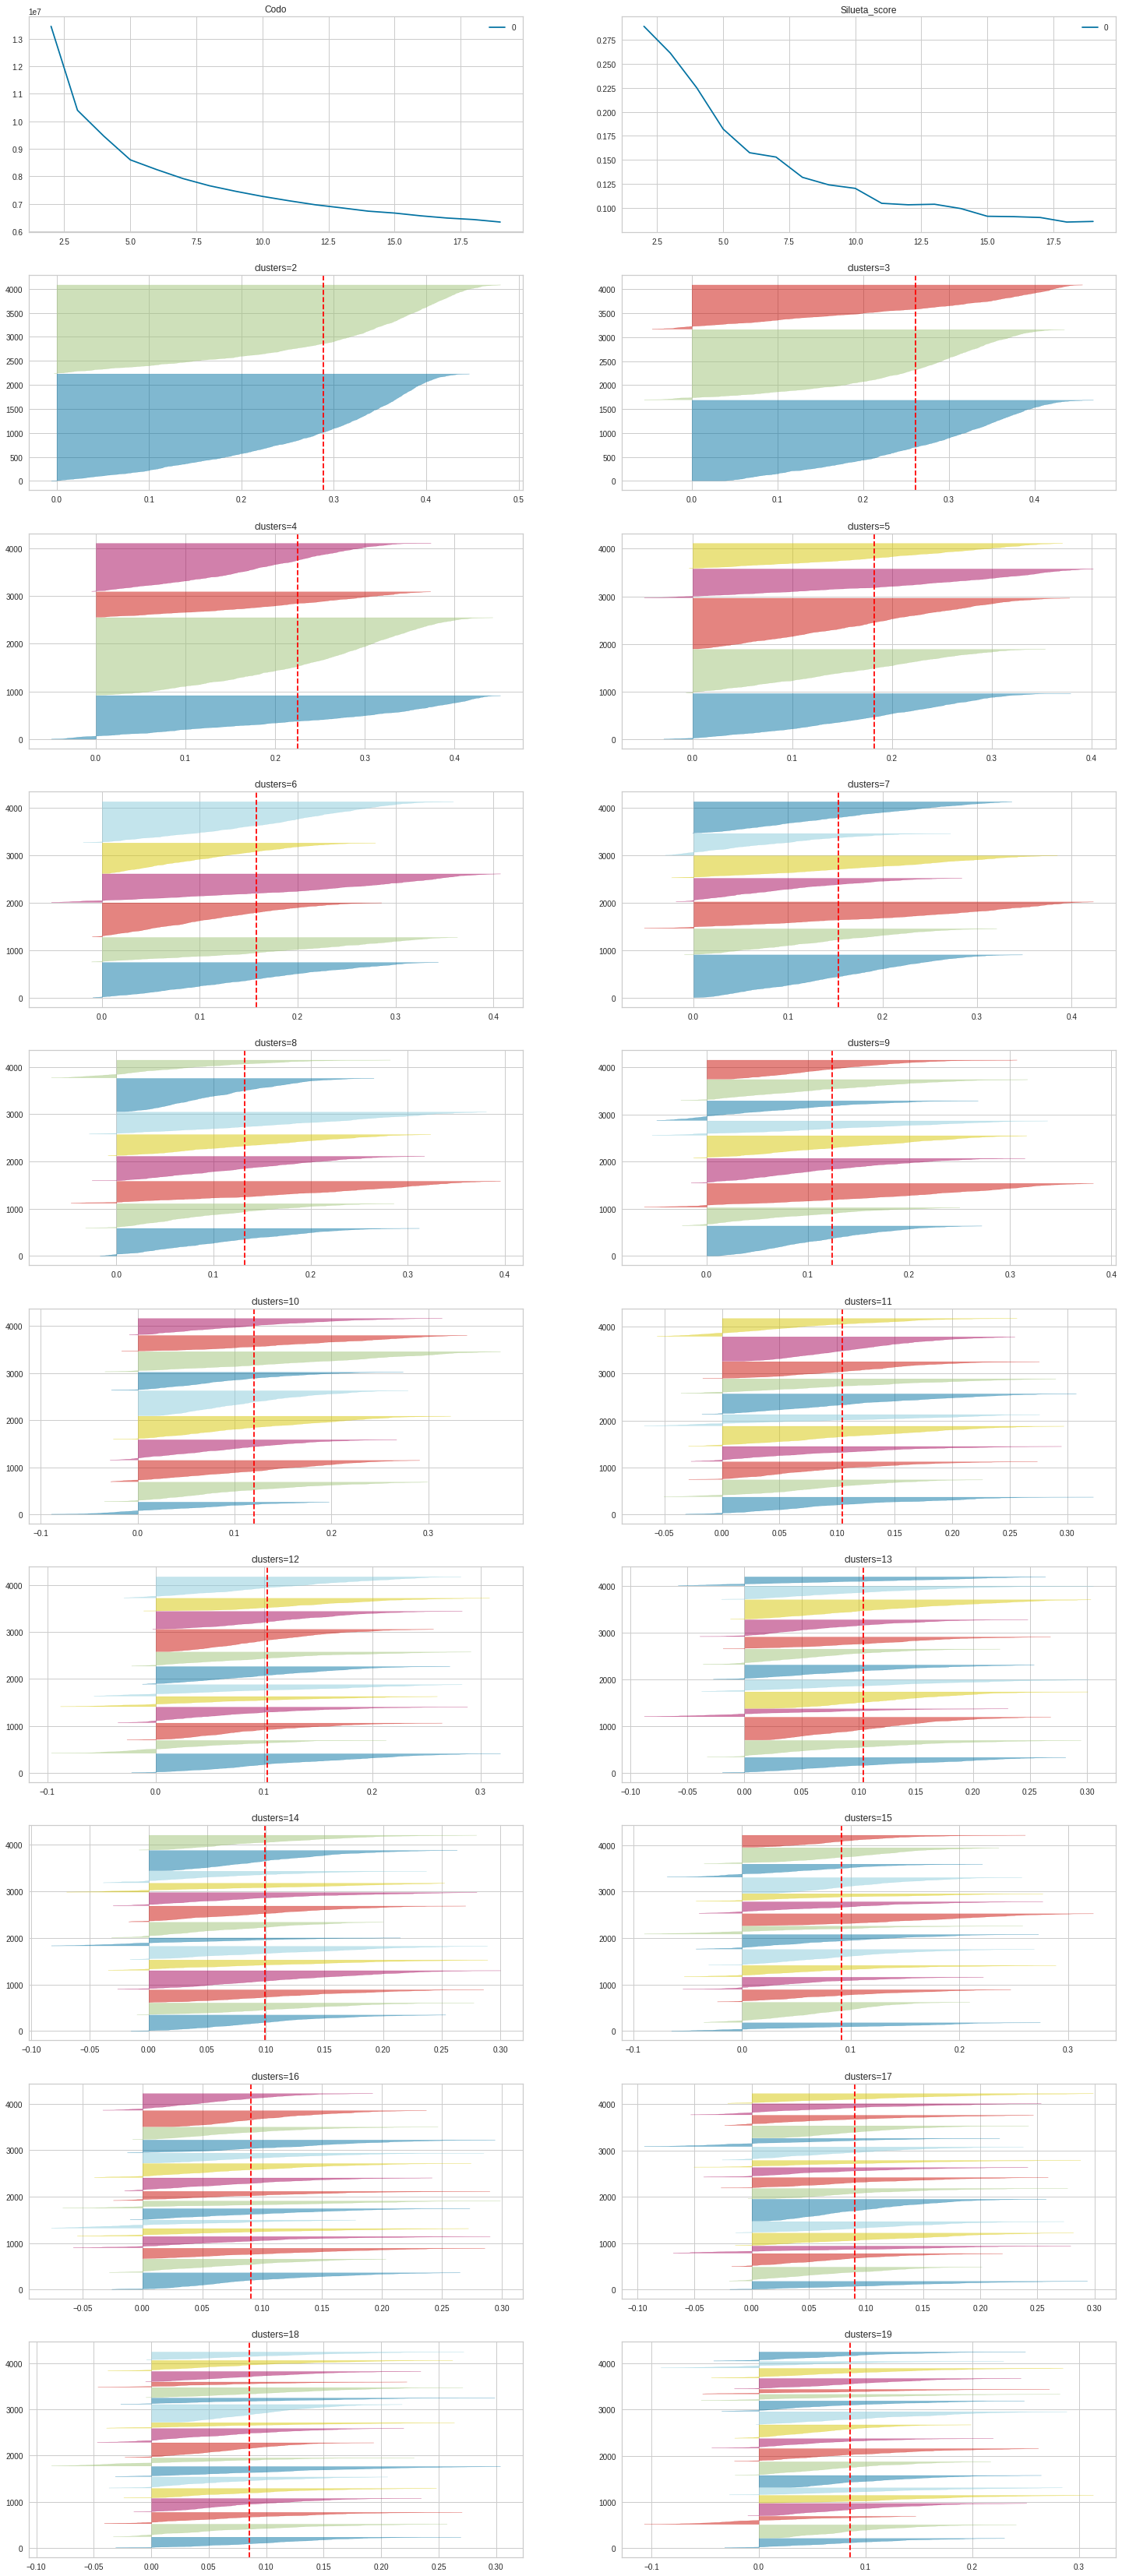

In [35]:
kmeans_estudio(data,iter=20,clusters_max=20)

Se observa que según el gráfico del codo, el número de clusters más optimos sería de 5 clusters, según las siluetas se observa que 2 clusters es el número optimo. Tampoco se descartaria ver con 3 clusters

In [36]:
km_2 = KMeans(n_clusters=2, max_iter=100,random_state=0).fit(data)
km_5 = KMeans(n_clusters=5, max_iter=100,random_state=0).fit(data)
km_3 = KMeans(n_clusters=3, max_iter=100,random_state=0).fit(data)

###**Mean Shift**

Busqueda del bandwith optimo en función del coeficiente de silueta

In [37]:
silueta_ms=[]
bandwith_ms=[]
for i in range(50,100,5):
  try:
    ms = MeanShift(bandwidth=i,bin_seeding=True,max_iter=100)
    pred=ms.fit_predict(data)
    silueta_ms.append(silhouette_score(data,pred))
    bandwith_ms.append(i)
    print(f'bandwidth:{i}, puntaje de silueta:{round(silhouette_score(data,pred),3)}')
  except:
    print(f'Error con bandwidth={i}')
    continue


Error con bandwidth=50
Error con bandwidth=55
Error con bandwidth=60
bandwidth:65, puntaje de silueta:0.444
bandwidth:70, puntaje de silueta:0.444
Error con bandwidth=75
Error con bandwidth=80
bandwidth:85, puntaje de silueta:0.658
bandwidth:90, puntaje de silueta:0.658
bandwidth:95, puntaje de silueta:0.658


In [38]:
best_band=bandwith_ms[silueta_ms.index(max(silueta_ms))]
print(f'Mejor bandwidth={best_band}')

Mejor bandwidth=85


Gráfico de los resultados

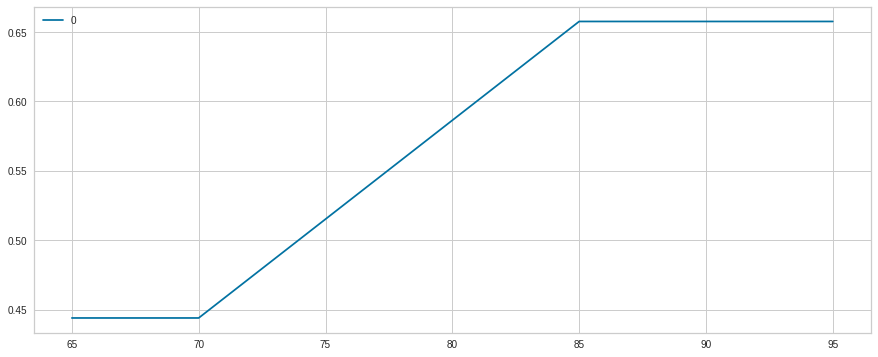

In [39]:
  pd.DataFrame(silueta_ms,index=bandwith_ms).plot(figsize=(15,6))

Elejimos el bandwith que mejora el valor de silueta que deberia ser lo más cercano a 1 y generamos los clusters con ese bandwith

In [40]:
ms = MeanShift(bandwidth=best_band)
clusters_ms=ms.fit_predict(data)

In [41]:
np.unique(clusters_ms)

array([0, 1])

In [42]:
(clusters_ms==1).sum()

1

In [43]:
(clusters_ms==0).sum()

4068

Se observa que mean_ shift llegó a 2 clusters, uno con 4068 jugadores y otro con 1 solo. 

In [44]:
data[(clusters_ms==0)]

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                     85                   95                          70   
1                     84                   95                          90   
3                     71                   94                          85   
4                     85                   87                          62   
5                     94                   82                          55   
...                  ...                  ...                         ...   
4505                  69                   60                          46   
4507                  76                   54                          54   
4508                  68                   68                          48   
4509                  67                   55                          51   
4511                  59                   70                          50   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
0                          91                 88               96   
1                          82                 86               88   
3                          84                 89               85   
4                          87                 87               95   
5                          94                 82               88   
...                       ...                ...              ...   
4505                       70                 49               71   
4507                       67                 55               70   
4508                       69                 61               73   
4509                       73                 51               73   
4511                       75                 61               73   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0              93                 94                  91                  96   
1              81                 76                  77                  92   
3              79                 85                  70                  88   
4              88                 89                  81                  95   
5              85                 83                  93                  92   
...           ...                ...                 ...                 ...   
4505           55                 60                  66                  72   
4507           74                 65                  64                  68   
4508           53                 42                  57                  71   
4509           81                 63                  71                  75   
4511           59                 59                  73                  74   

      movement_acceleration  movement_sprint_speed  movement_agility  \
0                        91                     80                91   
1                        87                     91                87   
3                        77                     78                77   
4                        94                     89                96   
5                        77                     76                78   
...                     ...                    ...               ...   
4505                     85                     83                82   
4507                     87                     85                77   
4508                     83                     82                81   
4509                     79                     73                80   
4511                     66                     67                74   

      movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                     94                95                86             68   
1                     95                71                94             95   
3                     93                82                89             84   
4                     91                83                80             62   
5                     91       

El jugador que se separa es Machine Gun, vamos a repetirlo sin machineGun

In [45]:
silueta_ms=[]
bandwith_ms=[]
for i in range(1,100,10):
  try:
    ms = MeanShift(bandwidth=i,bin_seeding=True,max_iter=100)
    pred=ms.fit_predict(data[(clusters_ms==0)])
    silueta_ms.append(silhouette_score(data[(clusters_ms==0)],pred))
    bandwith_ms.append(i)
    print(f'bandwidth:{i}, puntaje de silueta:{round(silhouette_score(data[(clusters_ms==0)],pred),3)}')
  except:
    print(f'Error con bandwidth={i}')
    continue


Error con bandwidth=1
Error con bandwidth=11
Error con bandwidth=21
Error con bandwidth=31
bandwidth:41, puntaje de silueta:0.195
Error con bandwidth=51
Error con bandwidth=61
bandwidth:71, puntaje de silueta:0.289
Error con bandwidth=81
Error con bandwidth=91


In [46]:
best_band=bandwith_ms[silueta_ms.index(max(silueta_ms))]
print(f'Mejor bandwidth={best_band}')

Mejor bandwidth=71


In [94]:
ms_2 = MeanShift(bandwidth=best_band)
clusters_ms_2=ms_2.fit_predict(data[(clusters_ms==0)])

In [95]:
np.unique(clusters_ms_2)

array([0, 1, 2])

In [96]:
for i in np.unique(clusters_ms_2):
  print((clusters_ms_2==i).sum())

3813
1
254


Se ve que plantea 3 clusters, hay uno que es solo un jugador

In [50]:
data[:-1][(clusters_ms_2==1)]

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
2480                  62                   41                          75   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
2480                       64                 57               59   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
2480           48                 63                  51                  71   

      movement_acceleration  movement_sprint_speed  movement_agility  \
2480                     79                     71                60   

      movement_reactions  movement_balance  power_shot_power  power_jumping  \
2480                  62                66                75             71   

      power_stamina  power_strength  power_long_shots  mentality_aggression  \
2480             72              78                72                    74   

      mentality_interceptions  mentality_positioning  mentality_vision  \
2480                       75                     49                62   

      mentality_penalties  mentality_composure  defending_standing_tackle  \
2480                   55                   65                         78   

      defending_sliding_tackle  goalkeeping_diving  goalkeeping_handling  \
2480                        76                  52                    61   

      goalkeeping_kicking  goalkeeping_positioning  goalkeeping_reflexes  
2480                   69                       66                    46

In [51]:
df_overall_70_SGK[:-1][(clusters_ms_2==1)]['short_name']

2226    Estevão Baldeiro
Name: short_name, dtype: object

Como conclusión se llega a que Estevão Baldeiro es unico en su clase

###**Jerárquico**

In [52]:
from sklearn.cluster import AgglomerativeClustering

In [53]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

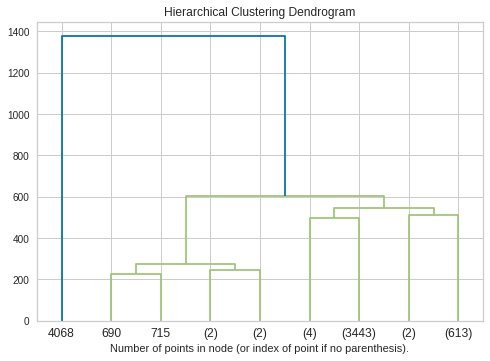

In [54]:
jer_model_man=AgglomerativeClustering(distance_threshold=0,n_clusters=None, linkage='average',affinity='manhattan')
jer_man = jer_model_man.fit(data)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
linkage_matrix_man=plot_dendrogram(jer_man, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

En el dendograma, se puede identificar visualmente el numero de clusters
deslizando una linea horizontal de abajo hacia arriba.

Observando se ve que hay dos grupos bien diferenciados, bajando en el eje y, tomando un valor de 400, se ve que se separan 5 clusters.

Se observan 2 clusters muy separados, uno con un solo jugador con index=4068:'Machine Gun', lo cual es logico. 
Disminuyendo la distancia se obser una separación del cluster más grande en dos subclusters, uno con 6 jugadores y otro con 4062.
Reduciendo la distancia empiezan a aparecer clusters nuevos pero tambien con pocos jugadores, con una distancia de 200 se ven 9 clustes, dos grandes con 3443 jugadores y 613 jugadores y 7 cluster con menos de 4 jugadores cada uno.

Se podria probar con otro criterio de distancia


##### **Separando los Clusters**

In [97]:
from scipy.cluster.hierarchy import fcluster

# Seleccionando la cantidad máxima de clusters
jer_labels_man = fcluster(linkage_matrix_man, 5, criterion='maxclust')
print(np.unique(jer_labels_man))

# Seleccionando a mano el corte en funcion de lo visto en el dendograma
#jer_labels_man = fcluster(linkage_matrix_man, 200, criterion='distance')
#print(np.unique(jer_labels_man))

[1 2 3 4 5]


In [98]:
print(np.unique(jer_labels_man))
for cl in np.unique(jer_labels_man):
  print(cl,(jer_labels_man==cl).sum())

[1 2 3 4 5]
1 6
2 3447
3 2
4 613
5 1


In [99]:
df_overall_70_SGK[jer_labels_man==1]

index                                         player_url  \
690     790  https://sofifa.com/player/154472/jorge-molina-...   
715     817   https://sofifa.com/player/189068/bas-dost/210002   
1598   1790  https://sofifa.com/player/162131/fernando-javi...   
2214   2468  https://sofifa.com/player/230449/diego-hugo-ra...   
2463   2744  https://sofifa.com/player/25798/roque-santa-cr...   
3116   3471  https://sofifa.com/player/179752/oscar-cardozo...   

          short_name                        long_name   age         dob  \
690     Jorge Molina               Jorge Molina Vidal  38.0  1982-04-22   
715          B. Dost                         Bas Dost  31.0  1989-05-31   
1598        Llorente  Fernando Javier Llorente Torres  35.0  1985-02-26   
2214  Diegildo Ramos          Diego Hugo Ramos Calado  28.0  1992-02-29   
2463   R. Santa Cruz    Roque Luis Santa Cruz Cantero  38.0  1981-08-16   
3116      O. Cardozo         Oscar René Cardozo Marín  37.0  1983-05-20   

      height_cm  weight_kg  nationality            club_name  \
690       188.0       72.0        Spain           Granada CF   
715       196.0       83.0  Netherlands  Eintracht Frankfurt   
1598      193.0       92.0        Spain               Napoli   
2214      185.0       80.0       Brazil             Flamengo   
2463      189.0       80.0     Paraguay     Olimpia Asunción   
3116      193.0       87.0     Paraguay        Club Libertad   

                        league_name  league_rank  overall  potential  \
690          Spain Primera Division          1.0     78.0       78.0   
715            German 1. Bundesliga          1.0     78.0       78.0   
1598                Italian Serie A          1.0     75.0       75.0   
2214  Campeonato Brasileiro Série A          1.0     74.0       74.0   
2463    Paraguayan Primera División          1.0     73.0       73.0   
3116    Paraguayan Primera División          1.0     72.0       72.0   

      value_eur  wage_eur player_positions preferred_foot  \
690   3700000.0   24000.0               ST          Right   
715   9500000.0   33000.0               ST          Right   
1598  3100000.0   41000.0               ST          Right   
2214  6000000.0     500.0           ST, RM           Left   
2463  1400000.0     500.0               ST          Right   
3116  1100000.0     500.0               ST           Left   

      international_reputation  weak_foot  skill_moves      work_rate  \
690                        1.0        4.0          3.0  Medium/Medium   
715                        3.0        3.0          2.0  Medium/Medium   
1598                       3.0        3.0          3.0  Medium/Medium   
2214                       1.0        3.0          2.0  Medium/Medium   
2463                       3.0        3.0          3.0  Medium/Medium   
3116                       2.0        3.0          3.0     Medium/Low   

     body_type real_face  release_clause_eur                player_tags  \
690     Normal        No           7800000.0                        NaN   
715       Lean        No          16200000.0  #Aerial Threat, #Strength   
1598    Normal        No           5300000.0  #Aerial Threat, #Strength   
2214    Normal        No          12600000.0                        NaN   
2463    Stocky        No           3100000.0                        NaN   
3116    Normal        No           2400000.0                  #Strength   

     team_position  team_jersey_number loaned_from      joined  \
690            SUB                23.0         NaN  2020-08-24   
715             RS                 9.0         NaN  2019-08-26   
1598           RES                87.0         NaN  2019-09-02   
2214           SUB                10.0         NaN  2019-01-01   
2463            RS                24.0         NaN  2016-06-17   
3116           SUB                 9.0         NaN  2017-07-01   

      contract_valid_until nation_position  nation_jersey_number  pace  \
690                 2022.0             NaN                  

#####**Probando con otra distancia**

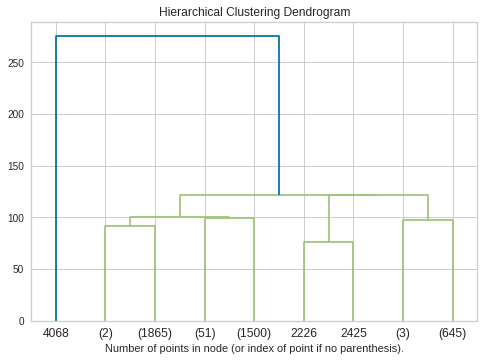

In [100]:
jer_model_euc=AgglomerativeClustering(distance_threshold=0,n_clusters=None, linkage='average',affinity='euclidean')
jer_euc = jer_model_euc.fit(data)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
linkage_matrix_euc=plot_dendrogram(jer_euc, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [101]:
jer_labels_euc = fcluster(linkage_matrix_euc, 5, criterion='maxclust')
print(np.unique(jer_labels_euc))
for cl in np.unique(jer_labels_euc):
  print(cl,(jer_labels_euc==cl).sum())

[1 2 3 4 5]
1 1867
2 1551
3 2
4 648
5 1


In [102]:
df_overall_70_SGK[jer_labels_euc==3]

index                                         player_url  \
2226   2480  https://sofifa.com/player/236108/estevao-danil...   
2425   2701  https://sofifa.com/player/236109/jorge-renato-...   

            short_name                      long_name   age         dob  \
2226  Estevão Baldeiro  Estevão Danilo Baldeiro Lopes  24.0  1996-02-29   
2425    Jorge Praceira    Jorge Renato Praceira Diniz  28.0  1992-02-29   

      height_cm  weight_kg nationality  club_name  \
2226      186.0       85.0      Brazil   Flamengo   
2425      180.0       74.0      Brazil  Palmeiras   

                        league_name  league_rank  overall  potential  \
2226  Campeonato Brasileiro Série A          1.0     74.0       74.0   
2425  Campeonato Brasileiro Série A          1.0     73.0       75.0   

      value_eur  wage_eur player_positions preferred_foot  \
2226  5500000.0     500.0               CB          Right   
2425  4000000.0     500.0               CB          Right   

      international_reputation  weak_foot  skill_moves    work_rate body_type  \
2226                       1.0        3.0          2.0    High/High    Stocky   
2425                       1.0        3.0          2.0  Medium/High    Normal   

     real_face  release_clause_eur player_tags team_position  \
2226        No          11600000.0         NaN           SUB   
2425        No           8700000.0         NaN           SUB   

      team_jersey_number loaned_from      joined  contract_valid_until  \
2226                 5.0         NaN  2019-01-01                2023.0   
2425                27.0         NaN  2019-01-01                2023.0   

     nation_position  nation_jersey_number  pace  shooting  passing  \
2226             NaN                   NaN  75.0      56.0     60.0   
2425             NaN                   NaN  66.0      40.0     56.0   

      dribbling  defending  physic  gk_diving  gk_handling  gk_kicking  \
2226       63.0       76.0    75.0        NaN          NaN         NaN   
2425       62.0       76.0    73.0        NaN          NaN         NaN   

      gk_reflexes  gk_speed  gk_positioning player_traits  attacking_crossing  \
2226          NaN       NaN             NaN           NaN                  62   
2425          NaN       NaN             NaN           NaN                  60   

      attacking_finishing  attacking_heading_accuracy  \
2226                   41                          75   
2425                   36                          81   

      attacking_short_passing  ...  movement_sprint_speed  movement_agility  \
2226                       64  ...                     71                60   
2425                       59  ...                     68                59   

      movement_reactions  movement_balance  power_shot_power  power_jumping  \
2226                  62                66                75             71   
2425                  64                63                51             66   

      power_stamina  power_strength  power_long_shots  mentality_aggression  \
2226             72              78                72                    74   
2425             71              76                38                    72   

      mentality_interceptions  mentality_positioning  mentality_vision  \
2226                       75                     49                62   
2425                       72                     42                47   

      mentality_penalties  mentality_composure  defending_marking  \
2226                   55                   65                NaN   
2425                   44                   46                NaN   

      defending_standing_tackle  defending_sliding_tackle  goalkeeping_diving  \
2226                         78                        76                  52   
2425                         76                        77                  54   

      goalkeeping_handling  goalkeeping_kicking  goalkeeping_positioning  \
2226                    61                

Se vuelve a separar Estevão Baldeiro, esta vez con otro jugador: Jorge Praceira

##**Análisis de los clusters encontrados.**


###**k-Medias**

In [61]:
# Recuperacion de etiquetas
clusters_2 = km_2.labels_
clusters_5 = km_5.labels_
clusters_3 = km_3.labels_

In [62]:
df_overall_70_SGK=df_overall_70[(df_overall_70['player_positions']!='GK')&(df_overall_70['team_position']!='GK')].reset_index()

Función de visualización

In [63]:
def visual(data,skill_1,skill_2,clusters,df_nombres):
  bool_crack= (df_nombres["overall"] > 85)
  bool_no_crack=(df_nombres["overall"]<86)
  model_clusters = go.Scatter(x=data[skill_1], y=data[skill_2],
                           mode='markers',
                        text=df_nombres.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

  crack =go.Scatter(x=data.loc[bool_crack.reset_index()['overall'].values,skill_1], y=data.loc[bool_crack.reset_index()['overall'].values,skill_2],name='Top players',
                      text=df_nombres.loc[bool_crack.reset_index()['overall'].values]['short_name'],
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,mode='text')

  data_p=[model_clusters,crack]

  layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

  fig = go.Figure(data=data_p, layout=layout)
  #En Colab
  fig.show(renderer="colab")
  

#### **Con 2 clusters**

In [105]:
#@title Seleccion de Skills
skill_1 = "attacking_finishing" #@param ["attacking_crossing", "attacking_finishing", "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed", "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength", "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning", "mentality_vision", "mentality_penalties", "mentality_composure", "defending_standing_tackle", "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", "goalkeeping_reflexes"]
skill_2 = "defending_standing_tackle" #@param ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

print(f'Skills seleccionados:\n{skill_1} y {skill_2}')

Skills seleccionados:
attacking_finishing y defending_standing_tackle


In [106]:
visual(data,skill_1,skill_2,clusters_2,df_overall_70_SGK)

Viendo una caracteristica de ataque como 'attacking_finishing' vs una de defensa como 'defending_standing_tackle', se ve que la diferenciación pareciera ser entre jugadores más ofensivos y más defensivos

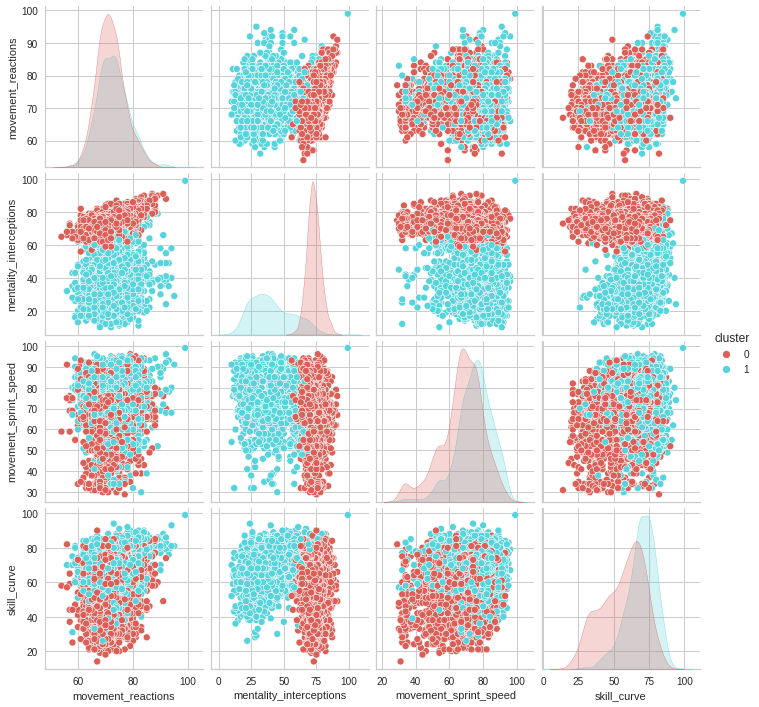

In [66]:
df_skills_cluster_km=df_skills_sin_arqueros[random.sample(skills_ratings,4)]
df_skills_cluster_km['cluster']=clusters_2
sns.pairplot(df_skills_cluster_km,hue='cluster',palette="hls")

#### **Con 3 Clusters**

In [67]:
#@title ####**Seleccion de Skills**
skill_1 = "attacking_finishing" #@param ["attacking_crossing", "attacking_finishing", "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed", "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength", "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning", "mentality_vision", "mentality_penalties", "mentality_composure", "defending_standing_tackle", "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", "goalkeeping_reflexes"]
skill_2 = "defending_standing_tackle" #@param ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

print(f'Skills seleccionados:\n{skill_1} y {skill_2}')

Skills seleccionados:
attacking_finishing y defending_standing_tackle


In [68]:
visual(data,skill_1,skill_2,clusters_3,df_overall_70_SGK)

Nuevamente viendo una caracteristica de ataque como 'attacking_finishing' vs una de defensa como 'defending_standing_tackle', se ve que se agregaría un nuevo cluster con jugadores intermedios.

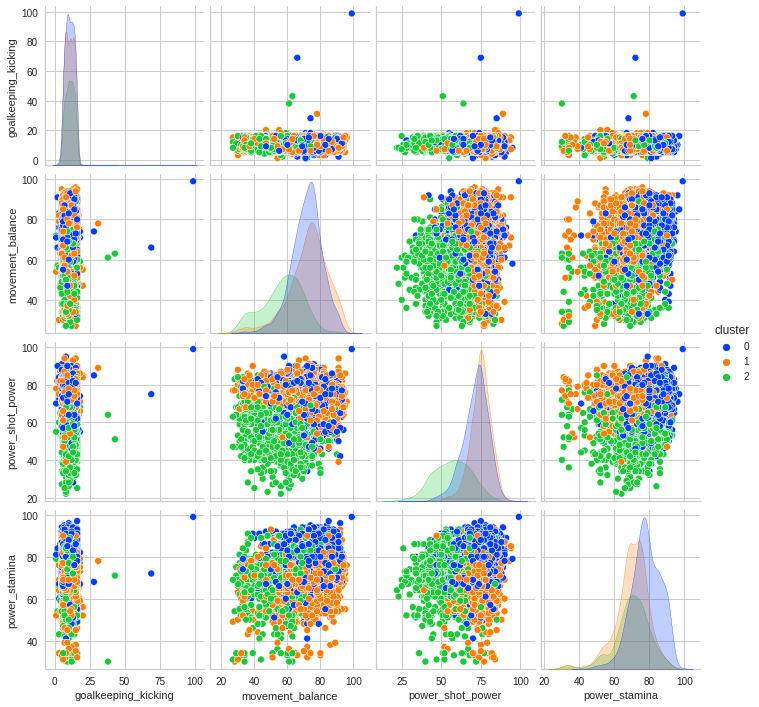

In [112]:
df_skills_cluster_km=df_skills_sin_arqueros[random.sample(skills_ratings,4)]
df_skills_cluster_km['cluster']=clusters_3
sns.pairplot(df_skills_cluster_km,hue='cluster',palette="bright")

#####**Grafico en 3D**

In [192]:
#@title ####**Seleccion de Skills**
skill_1 = "skill_long_passing" #@param ["attacking_crossing", "attacking_finishing", "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed", "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength", "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning", "mentality_vision", "mentality_penalties", "mentality_composure", "defending_standing_tackle", "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", "goalkeeping_reflexes"]
skill_2 = "movement_balance" #@param ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
skill_3 = "attacking_volleys" #@param ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

print(f'Skills seleccionados:\n{skill_1} ; {skill_2} ; {skill_3}')

Skills seleccionados:
skill_long_passing ; movement_balance ; attacking_volleys


In [188]:
centros=km_3.cluster_centers_

In [193]:
df_grafico=pd.DataFrame()
df_grafico['x']=data.reset_index()[skill_1]
df_grafico['y']=data.reset_index()[skill_2]
df_grafico['z']=data.reset_index()[skill_3]
df_grafico['name']=df_overall_70_SGK.loc[:,'short_name']
df_grafico['prediction']=km_3.labels_

In [194]:
df_centros=pd.DataFrame()
df_centros['x']=centros[:,skills_ratings.index(skill_1)]
df_centros['y']=centros[:,skills_ratings.index(skill_2)]
df_centros['z']=centros[:,skills_ratings.index(skill_3)]
df_centros['prediction']=pd.DataFrame(centros).index
df_centros['name']=np.array(['Cluster nº1','Cluster nº2','Cluster nº3'])

In [195]:
plot_clustering(df_grafico,df_centros,skill_1,skill_2,skill_3)

#### **Con 5 Clusters**

In [70]:
#@title ####**Seleccion de Skills**
skill_1 = "attacking_finishing" #@param ["attacking_crossing", "attacking_finishing", "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed", "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength", "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning", "mentality_vision", "mentality_penalties", "mentality_composure", "defending_standing_tackle", "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", "goalkeeping_reflexes"]
skill_2 = "defending_sliding_tackle" #@param ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

print(f'Skills seleccionados:\n{skill_1} y {skill_2}')

Skills seleccionados:
attacking_finishing y defending_sliding_tackle


In [71]:
visual(data,skill_1,skill_2,clusters_5,df_overall_70_SGK)

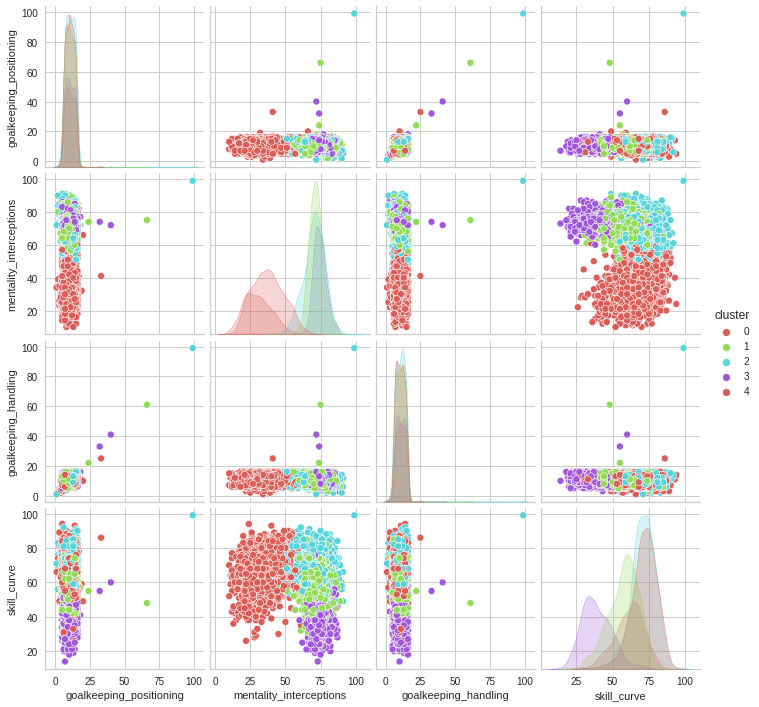

In [72]:
df_skills_cluster_km=df_skills_sin_arqueros[random.sample(skills_ratings,4)]
df_skills_cluster_km['cluster']=clusters_5
sns.pairplot(df_skills_cluster_km,hue='cluster',palette="hls")

#####**Grafico en 3D**

In [139]:
#@title ####**Seleccion de Skills**
skill_1 = "attacking_finishing" #@param ["attacking_crossing", "attacking_finishing", "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed", "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength", "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning", "mentality_vision", "mentality_penalties", "mentality_composure", "defending_standing_tackle", "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", "goalkeeping_reflexes"]
skill_2 = "skill_long_passing" #@param ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
skill_3 = "attacking_heading_accuracy" #@param ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

print(f'Skills seleccionados:\n{skill_1} ; {skill_2} ; {skill_3}')

Skills seleccionados:
attacking_finishing ; skill_long_passing ; attacking_heading_accuracy


In [140]:
centros=km_5.cluster_centers_

In [141]:
df_grafico=pd.DataFrame()
df_grafico['x']=data.reset_index()[skill_1]
df_grafico['y']=data.reset_index()[skill_2]
df_grafico['z']=data.reset_index()[skill_3]
df_grafico['name']=df_overall_70_SGK.loc[:,'short_name']
df_grafico['prediction']=km_5.labels_

In [142]:
df_centros=pd.DataFrame()
df_centros['x']=centros[:,skills_ratings.index(skill_1)]
df_centros['y']=centros[:,skills_ratings.index(skill_2)]
df_centros['z']=centros[:,skills_ratings.index(skill_3)]
df_centros['prediction']=pd.DataFrame(centros).index
df_centros['name']=np.array(['Cluster nº1','Cluster nº2','Cluster nº3','Cluster nº4','Cluster nº5'])

In [143]:
plot_clustering(df_grafico,df_centros,skill_1,skill_2,skill_3)

###**Mean Shift**

In [78]:
#@title Seleccion de Skills
skill_1 = "defending_standing_tackle" #@param ["attacking_crossing", "attacking_finishing", "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed", "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength", "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning", "mentality_vision", "mentality_penalties", "mentality_composure", "defending_standing_tackle", "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", "goalkeeping_reflexes"]
skill_2 = "attacking_finishing" #@param ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

print(f'Skills seleccionados:\n{skill_1} y {skill_2}')

Skills seleccionados:
defending_standing_tackle y attacking_finishing


In [79]:
bool_crack= (df_overall_70_SGK[(df_overall_70_SGK["short_name"] !='MachineGun')].reset_index()["overall"] > 85)
bool_no_crack=(df_overall_70_SGK[(df_overall_70_SGK["short_name"] !='MachineGun')].reset_index()["overall"]<86)

In [80]:
clusters_ms_2

array([0, 0, 0, ..., 0, 0, 0])

In [81]:
visual(data[:-1].reset_index(),skill_1,skill_2,clusters_ms_2,df_overall_70_SGK[(df_overall_70_SGK["short_name"] !='MachineGun')].reset_index())

No son muy buenos los resultados comparado a k Means

###**Jerárquico**

In [82]:
#@title Seleccion de Skills
skill_1 = "defending_standing_tackle" #@param ["attacking_crossing", "attacking_finishing", "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed", "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength", "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning", "mentality_vision", "mentality_penalties", "mentality_composure", "defending_standing_tackle", "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", "goalkeeping_reflexes"]
skill_2 = "attacking_finishing" #@param ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

print(f'Skills seleccionados:\n{skill_1} y {skill_2}')

Skills seleccionados:
defending_standing_tackle y attacking_finishing


In [83]:
jer_labels_euc

array([2, 2, 2, ..., 1, 1, 5], dtype=int32)

In [84]:
visual(data.reset_index(),skill_1,skill_2,jer_labels_euc,df_overall_70_SGK.reset_index())

In [85]:
#@title ####**Seleccion de Skills**
skill_1 = "attacking_finishing" #@param ["attacking_crossing", "attacking_finishing", "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed", "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength", "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning", "mentality_vision", "mentality_penalties", "mentality_composure", "defending_standing_tackle", "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", "goalkeeping_reflexes"]
skill_2 = "power_jumping" #@param ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
skill_3 = "defending_standing_tackle" #@param ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

print(f'Skills seleccionados:\n{skill_1} ; {skill_2} ; {skill_3}')

Skills seleccionados:
attacking_finishing ; power_jumping ; defending_standing_tackle


In [86]:
df_grafico=pd.DataFrame()
df_grafico['x']=data.reset_index()[skill_1]
df_grafico['y']=data.reset_index()[skill_2]
df_grafico['z']=data.reset_index()[skill_3]
df_grafico['name']=df_overall_70_SGK.loc[:,'short_name']
df_grafico['prediction']=jer_labels_euc

In [87]:
plot_clustering(df_grafico,pd.DataFrame(),skill_1,skill_2,skill_3)

##**Embeddings y técnicas de clustering.**


###**PCA**

In [167]:
print('los datos tienen dimesión n= ',len(skills_ratings))

los datos tienen dimesión n=  33


In [162]:
pca=PCA(n_components=16)

Explained variance: 
[2297.9506  849.1065  490.7642  265.0022  120.0834  104.2826   87.7318
   72.8536   70.2214   69.7819   61.2716   49.6312   43.8556   40.0257
   39.3024   34.5901]
Explained variance ratio
[0.4617 0.1706 0.0986 0.0532 0.0241 0.021  0.0176 0.0146 0.0141 0.014
 0.0123 0.01   0.0088 0.008  0.0079 0.007 ]
15 0.943658171109331


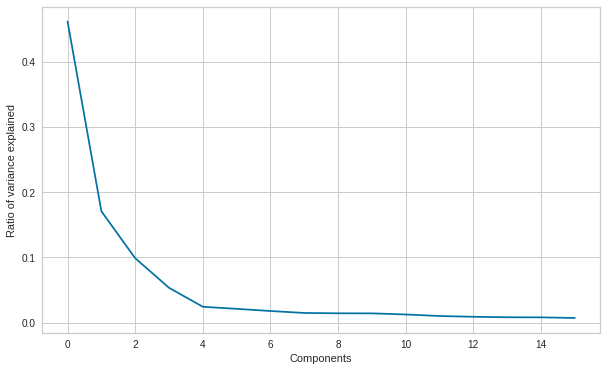

In [163]:
pca.fit(data)
#Obtenemos n componentes principales
proyected_features = pca.transform(data)

print("Explained variance: ")
print(pca.explained_variance_.round(4))
print("Explained variance ratio")
print(pca.explained_variance_ratio_.round(4))
  #proyected_features.shape

  #Porcentaje  de varianza para los primeros n componentes principales
fig = plt.figure(figsize=(10,6))
sns.lineplot(x=range(pca.n_components),
                  y=pca.explained_variance_ratio_,)

plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")

porcentaje=0.95
suma=0
for component in range(pca.n_components):

  suma+=pca.explained_variance_ratio_[component]
  if suma>=porcentaje:
    #print(component)
    break
print(component,suma)


Las primeras 4 componentes son las que representan 77% de la varianza y las primeras 15 el 95%

In [169]:
std_scale=StandardScaler().fit(data)
data_scaled=std_scale.transform(data) # numpyarray Estandarizado (le resta la media y divide por el desvío) por columna

**Se realizó una normalización estandar para realizar el metodo de PCA, para evitar que los skills con mayor rango influencien más al elegir las componentes**

Explained variance: 
[11.4422  4.1366  3.2662  2.2203  1.8336  1.0417  0.7826  0.7294  0.7153
  0.6999  0.6734  0.5801  0.5556  0.4766  0.4541  0.3923]
Explained variance ratio
[0.3466 0.1253 0.099  0.0673 0.0555 0.0316 0.0237 0.0221 0.0217 0.0212
 0.0204 0.0176 0.0168 0.0144 0.0138 0.0119]
15 0.9088619831090553


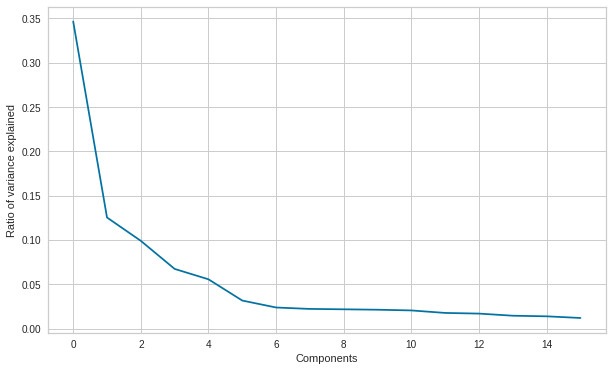

In [170]:
pca.fit(data_scaled)
#Obtenemos n componentes principales
proyected_features = pca.transform(data_scaled)

print("Explained variance: ")
print(pca.explained_variance_.round(4))
print("Explained variance ratio")
print(pca.explained_variance_ratio_.round(4))
  #proyected_features.shape

  #Porcentaje  de varianza para los primeros n componentes principales
fig = plt.figure(figsize=(10,6))
sns.lineplot(x=range(pca.n_components),
                  y=pca.explained_variance_ratio_,)

plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")

porcentaje=0.95
suma=0
for component in range(pca.n_components):

  suma+=pca.explained_variance_ratio_[component]
  if suma>=porcentaje:
    #print(component)
    break
print(component,suma)


In [178]:
pca=PCA(n_components=3) #elegimos 2, 3 o 4 pero pueden ser más, 

pca.fit(data_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(X_scaled) #numpy array
print ('tamaño de los datos: ', X_projected.shape)

proporción de varianza por componente:  [0.34664851 0.1253199  0.09895154]
proporción de varianza por componente acumulada:  [0.34664851 0.47196841 0.57091995]
tamaño de los datos:  (4069, 3)


Las 3 primeras componentes con los datos escalados dan una varianza acumulada de 57%

In [180]:
#Graph 1
data_pca=[]
pcs=pca.components_  #"composición" de las primeras componentes, 
for i, (x,y) in enumerate(zip(pcs[0,:],pcs[1,:])):
    graph=go.Scatter(x=[0,x],y=[0,y],text=data.columns[i],
                     mode='lines+markers+text',textposition='top left',textfont=dict(family='sans serif',size=15))
    data_pca.append(graph)

layout = go.Layout(title="ACP - Fifa Skills",titlefont=dict(size=20),
            xaxis=dict(title='Componente 1'),
            yaxis=dict(title='Componente 2'),
            autosize=False, width=1050,height=750,
            showlegend=False)

fig = go.Figure(data=data_pca, layout=layout)
#plot(fig)
#En Colab
fig.show(renderer="colab")

In [181]:
#Graph 1
data_pca=[]
pcs=pca.components_  #"composición" de las primeras componentes, 
for i, (x,y) in enumerate(zip(pcs[1,:],pcs[2,:])):
    graph=go.Scatter(x=[0,x],y=[0,y],text=data.columns[i],
                     mode='lines+markers+text',textposition='top left',textfont=dict(family='sans serif',size=15))
    data_pca.append(graph)

layout = go.Layout(title="ACP - Fifa Skills",titlefont=dict(size=20),
            xaxis=dict(title='Componente 2'),
            yaxis=dict(title='Componente 3'),
            autosize=False, width=1050,height=750,
            showlegend=False)

fig = go.Figure(data=data_pca, layout=layout)
#plot(fig)
#En Colab
fig.show(renderer="colab")

####**Clustering**



##### **kMeans**

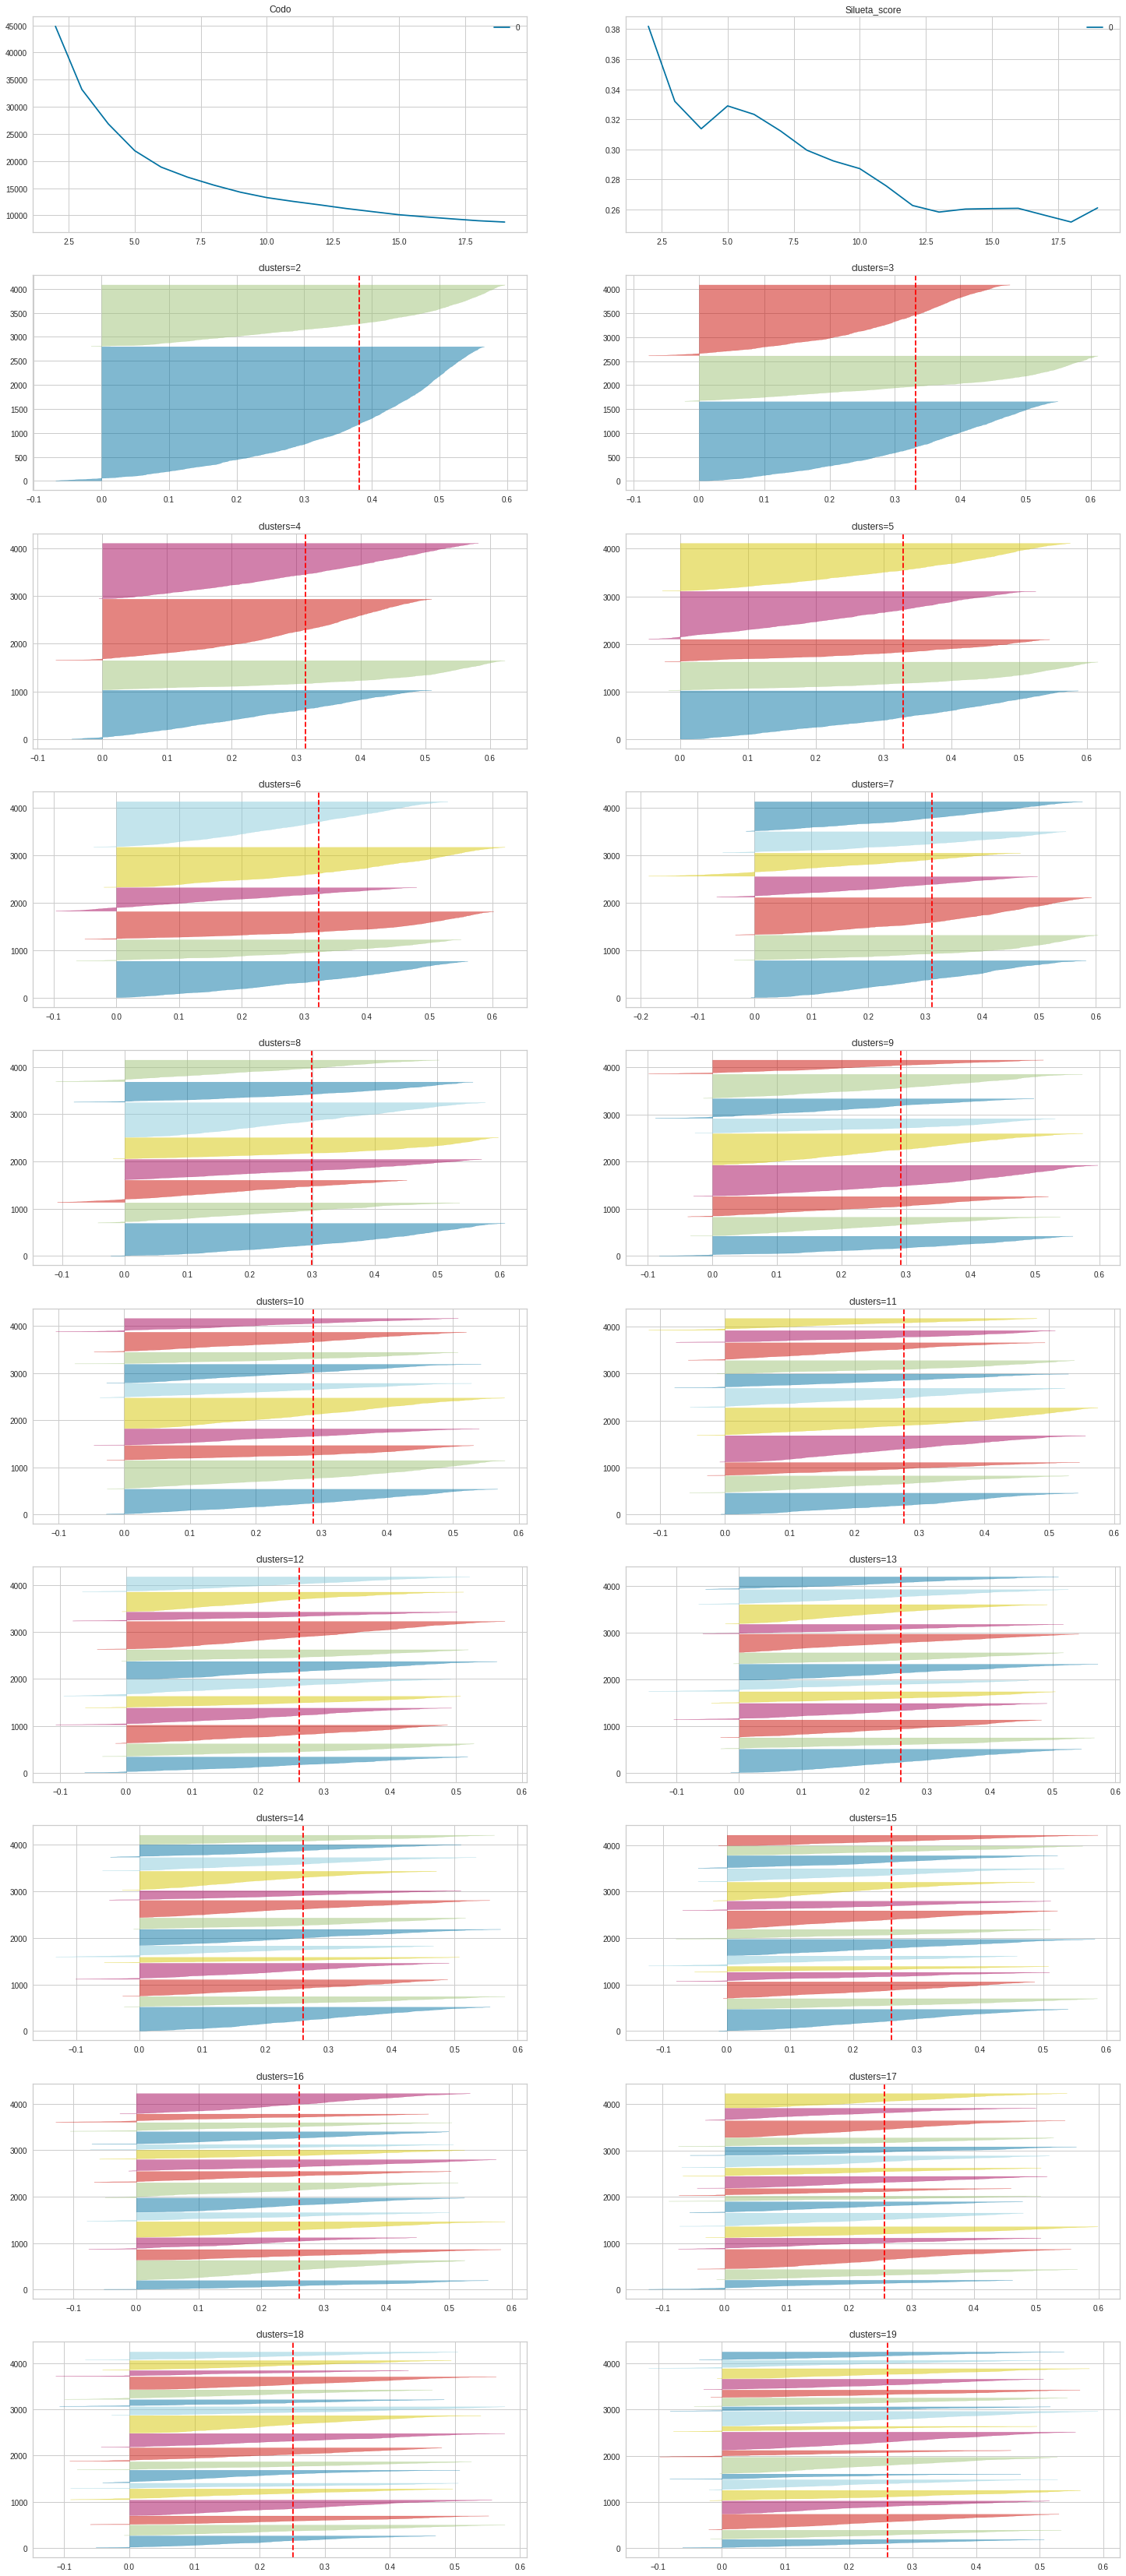

In [196]:
kmeans_estudio(X_projected,iter=20,clusters_max=20)

##### **Con 3 Clusters**

Elegimos 3 clusters

In [199]:
km_3_pca = KMeans(n_clusters=3, max_iter=100,random_state=0).fit(X_projected)

In [208]:
len(X_projected)

4069

In [202]:
km_3_pca.labels_

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

In [200]:
centros=km_3_pca.cluster_centers_

In [218]:
data_projected=pd.DataFrame(X_projected,columns=['Componente_n1','Componente_n2','Componente_n3'])

In [219]:
data_projected

Componente_n1  Componente_n2  Componente_n3
0         -9.602654       3.167088       1.686293
1         -7.567216       2.263183       3.503456
2         -6.147449       2.386784       4.040076
3         -9.164752       2.048180       0.587823
4         -7.276338       5.678651       1.451532
...             ...            ...            ...
4064      -0.786812      -1.443085      -3.709798
4065      -1.840104      -3.860358      -1.169654
4066      -1.158195       1.673197      -0.946566
4067      -0.646933       1.496422       0.043036
4068      -9.153786      13.467721       4.380065

[4069 rows x 3 columns]

In [221]:
df_grafico=pd.DataFrame()
df_grafico['x']=data_projected['Componente_n1']
df_grafico['y']=data_projected['Componente_n2']
df_grafico['z']=data_projected['Componente_n3']
df_grafico['name']=df_overall_70_SGK.loc[:,'short_name']
df_grafico['prediction']=km_3_pca.labels_

In [223]:
plot_clustering(df_grafico,pd.DataFrame(),'Componente_n1','Componente_n2','Componente_n3')

#**Conclusiones**

* Se observo que mean shift se ve influenciado más por los valores atipicos (machine gun).
* Mean shift demora más en su implementación.
* El dendograma del metodo jerarquico se interpreta facilmente.
* El metodo jerarquico es invariable a la precencia de machine gun (outlier), ya que el resto de los jugadores se sigue separando de la misma manera este este o no en el data set.
* Definitivamente hacer clustering luego del metodo de las componentes principales, nos permitió la mejor separación de los datos